In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from utils import train_and_plot_learning_curve

In [2]:
df = pd.read_csv('../data/features/train.csv', sep=';', index_col=0)

df['foundation_type'] = df['foundation_type'].astype('category')
df['concrete_code'] = df['concrete_code'].astype('category')
df['load_code'] = df['load_code'].astype('category')
df['wind_code'] = df['wind_code'].astype('category')
df['seismic_code'] = df['seismic_code'].astype('category')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 0 to 1653
Data columns (total 78 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   foundation_type             1654 non-null   category
 1   concrete_code               1654 non-null   category
 2   load_code                   1654 non-null   category
 3   wind_code                   1654 non-null   category
 4   seismic_code                1654 non-null   category
 5   floor_number                1654 non-null   int64   
 6   total_height                1654 non-null   float64 
 7   height                      1654 non-null   float64 
 8   foundation_height           1654 non-null   float64 
 9   double_height               1654 non-null   float64 
 10  triple_height               1654 non-null   float64 
 11  support_column              1654 non-null   int64   
 12  unsupported_column          1654 non-null   int64   
 13  walls_number      

## Preparando los datos

In [4]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, make_column_selector(dtype_include='category')),
    ],
    remainder=default_num_pipeline) 

# Datos de entrada

In [5]:
df = df.drop(['center_x', 'center_y', 'cdm_x', 'cdm_y', 'cdr_x', 'cdr_y'], axis=1)

In [6]:
X = df.drop("reinf_steel_ratio", axis=1)
y = df["reinf_steel_ratio"].copy()

In [7]:
len(X.columns)

71

In [8]:
X.columns

Index(['foundation_type', 'concrete_code', 'load_code', 'wind_code',
       'seismic_code', 'floor_number', 'total_height', 'height',
       'foundation_height', 'double_height', 'triple_height', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'support_area', 'walls_area', 'retaining_walls_area', 'LL', 'DL',
       'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc',
       'slab_total_area', 'flat_slab_area', 'waffle_slab_area', 'depth',
       'drop_panel_area', 'domes_area', 'domes_number', 'inter_axis_distance',
       'shape_factor', 'x_length', 'y_length', 'concrete_m3_ratio',
       'slab_area_mean', 'height_mean', 'double_height_ratio',
       'triple_height_ratio', 'slenderness', 'column_area', 'swall_num',
       'swall_area', 'swall_area_mean', 'col_area_mean', 'rwalls_area_mean',
       'swall_area_mean_m2', 'col_area_mean_m2', 'rwalls_area_mean_m2',
       'swall_area_ratio', 'col_area_ratio', 'rwals_area_ratio', 

# Neural Network

In [9]:
MAX_ITER = 10_000

In [10]:
%%time
nn = make_pipeline(preprocessing, MLPRegressor(early_stopping=True, random_state=42, max_iter=MAX_ITER))
nn_mapes = cross_val_score(nn, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)

CPU times: user 1min 41s, sys: 4min 31s, total: 6min 13s
Wall time: 24 s


In [11]:
nn_mapes

array([0.09924462, 0.07574429, 0.0789335 , 0.09937694, 0.0867126 ,
       0.08493155, 0.11115743, 0.09627725, 0.07777369, 0.09947383])

In [12]:
pd.Series(nn_mapes).describe()

count    10.000000
mean      0.090963
std       0.011797
min       0.075744
25%       0.080433
50%       0.091495
75%       0.099344
max       0.111157
dtype: float64

CPU times: user 1.56 s, sys: 2 s, total: 3.57 s
Wall time: 32.4 s


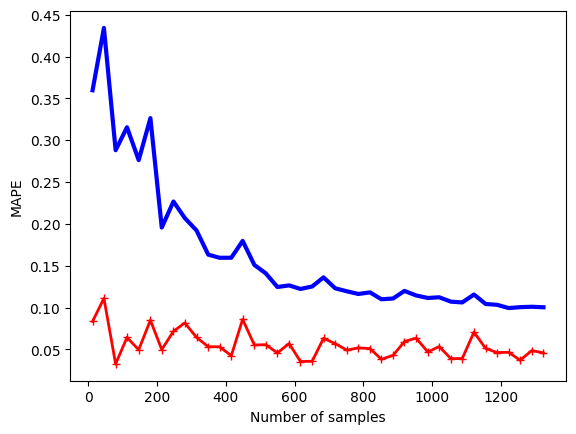

In [13]:
%%time
fig, ax = train_and_plot_learning_curve(nn, X, y)
fig.savefig('../reports/figures/train/default_mlpr_cv.pdf', bbox_inches='tight')

# Grid Search

In [14]:
%%time

mlpr = make_pipeline(preprocessing, MLPRegressor(early_stopping=True, random_state=42, max_iter=MAX_ITER))

parameters = {
 'mlpregressor__hidden_layer_sizes': [(40,), (50,), (60,)],
 'mlpregressor__batch_size': [32, 64, 128],
 'mlpregressor__learning_rate_init': [0.005, 0.01, 0.015],
 }

mlpr_grid = GridSearchCV(mlpr, parameters, n_jobs=-1, cv=10, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
mlpr_grid.fit(X, y)

CPU times: user 2.89 s, sys: 3.4 s, total: 6.29 s
Wall time: 18.6 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f1408388c10>)])),
                                       ('mlpregressor',
                                        MLPRegressor(early_stopping=True,
                                                     max_iter=10000,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'mlpregressor__batch_size': [32, 64, 128],
                         'mlpregressor__hidden_layer_sizes': [(40,), (50,),
                                                              (60,)],
                         'mlpregressor__learning_rate_init': [0.005, 0.01,
                                                              0.015]},
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [15]:
mlpr_grid.best_params_

{'mlpregressor__batch_size': 128,
 'mlpregressor__hidden_layer_sizes': (50,),
 'mlpregressor__learning_rate_init': 0.015}

# Best Model

In [16]:
best_params = {key.split('__')[-1]: value for key, value in mlpr_grid.best_params_.items()}
best_params

{'batch_size': 128, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.015}

In [17]:
%%time
mlpr = make_pipeline(preprocessing, MLPRegressor(early_stopping=True, random_state=42, max_iter=MAX_ITER, **best_params))
mlpr_mapes = cross_val_score(mlpr, X, y, scoring=make_scorer(mean_absolute_percentage_error), cv=10)
pd.Series(mlpr_mapes).describe()

CPU times: user 22.8 s, sys: 1min 2s, total: 1min 25s
Wall time: 5.6 s


count    10.000000
mean      0.088512
std       0.012147
min       0.071171
25%       0.080128
50%       0.088093
75%       0.097758
max       0.106556
dtype: float64

/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:598: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:598: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:598: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/pablo/miniconda3/envs/steel-ml-model/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:598: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/home/pablo/miniconda3/envs/steel-ml-model/l

CPU times: user 1.17 s, sys: 1.29 s, total: 2.45 s
Wall time: 5.33 s


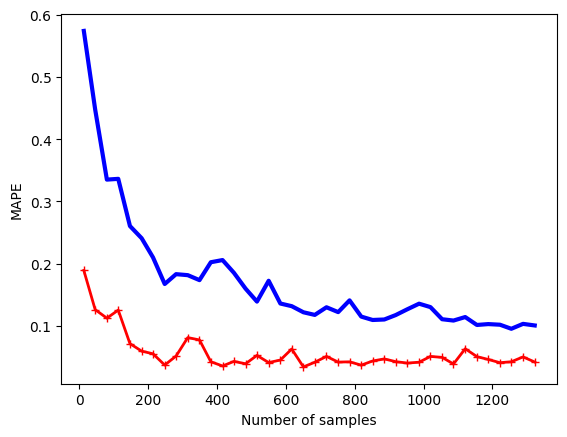

In [18]:
%%time
fig, ax = train_and_plot_learning_curve(mlpr, X, y)
fig.savefig('../reports/figures/train/best_mlpr_cv.pdf', bbox_inches='tight')